1.7040247556147737e-05
(0.2743433190292394, 0.4322958978570361)
0.0002505443655988606
(-0.842216165553134, 0.18825761732523844)


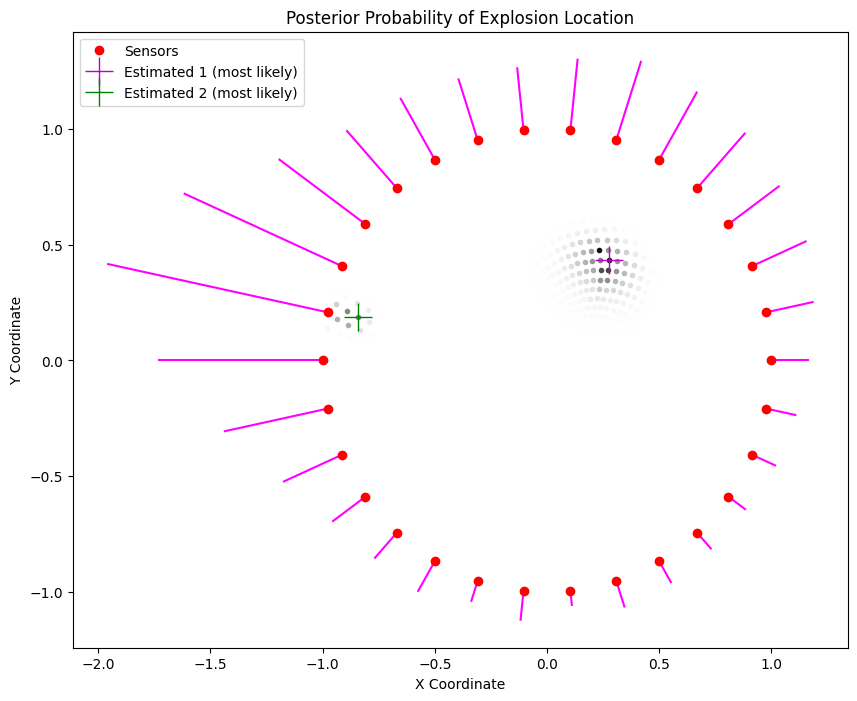

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def value(x_true, y_true, x_sensor, y_sensor):
    return 1 / (0.1 + (x_true - x_sensor)**2 + (y_true - y_sensor)**2)

def earthquake(v_observed, n):
    # Define the coordinate system:
    S = 2000  # number of points on the spiral
    theta = 55 * 2 * np.pi * np.arange(S) / S
    r = np.arange(S) / S
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Define the locations of the detection stations on the surface
    N = len(v_observed)  # number of stations (will be overwritten by file length)
    theta_sensor = 2 * np.pi * np.arange(N) / N
    x_sensor = np.cos(theta_sensor)
    y_sensor = np.sin(theta_sensor)

    # Calculate the explosion values for the sensors
    v = np.zeros((S, N))
    for sensor in range(N):
        for s in range(S):
            v[s, sensor] = value(x[s], y[s], x_sensor[sensor], y_sensor[sensor])
    
    # Perform inference p(location|observed sensor values) given these sensor values
    max_prob = 0
    logp1 = np.zeros(S)
    logp2 = np.zeros(S)
    for s in range(S):
        loc_prob = 0
        for s2 in range(S):
            #if s == s2:
            #    continue
            combined = 0
            for sensor in range(N):
                calc1 = value(x[s], y[s], x_sensor[sensor], y_sensor[sensor])
                calc2 = value(x[s2], y[s2], x_sensor[sensor], y_sensor[sensor])
                combined += -0.5 * (v_observed[sensor] - (calc1+calc2))**2
            combined = np.exp(combined)
            if combined > loc_prob:
                loc_prob = combined
                logp1[s] = loc_prob
                #print('p1 ',logp1[s])
                logp2[s2] = loc_prob
                #print('p2 ',logp2[s2])
            if combined > max_prob:
                max_prob = combined
                max_idx = (s, s2)

    p1 = logp1 - np.max(logp1)
    p1 /= np.sum(p1)
    p2 = logp2 - np.max(logp2)
    p2 /= np.sum(p2)

    px = (p1+p2)/2

    logp = logp1 + logp2

    #p = logp - np.max(logp)  # do exponentiation (and avoid over/underflow)
    #p /= np.sum(p)  # normalize
    
    # Plot the posterior and most likely location of the explosion:
    maxp = np.max(px)
    #print(max_idx)
    #print(max_idx.shape)

    #print(px.shape)
    #print(px[256])
    #print(max_idx[0])
    #print(max_idx[1])

    print(px[max_idx[0]])
    print((x[max_idx[0]], y[max_idx[0]]))
    print(px[max_idx[1]])
    print((x[max_idx[1]], y[max_idx[1]]))
    
    plt.figure(figsize=(10, 8))
    for s in range(S):
        plt.plot(x[s], y[s], ".", color=((px[s] / maxp)) * np.ones(3))
 
    for sensor in range(N):
    # Normalize the line length to the observed data
        line_length = v_observed[sensor] / np.max(v_observed)
        plt.plot([x_sensor[sensor], x_sensor[sensor] * (1 + line_length)],
                [y_sensor[sensor], y_sensor[sensor] * (1 + line_length)],
                color='magenta')
    
    plt.plot(x_sensor, y_sensor, "ro", label="Sensors")
    plt.plot(x[max_idx[0]], y[max_idx[0]], "m+", markersize=20, label="Estimated 1 (most likely)")
    plt.plot(x[max_idx[1]], y[max_idx[1]], "g+", markersize=20, label="Estimated 2 (most likely)")
    plt.legend()
    plt.title('Posterior Probability of Explosion Location')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

    return logp1, logp2

# Read observed values from file
with open("EarthquakeExerciseData.txt") as f:
    lines = f.readlines()
v_observed = [float(line.strip()) for line in lines]
num_explosions = 2

p1, p2 = earthquake(v_observed, num_explosions)
